In [1]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle

%matplotlib inline

def flatten_dict(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            val = [val]
        if isinstance(val, list):
            for subdict in val:
                deeper = flatten_dict(subdict).items()
                out.update({key + '.' + key2: val2 for key2, val2 in deeper})
        else:
            out[key] = val
    return out

# prefix = "../vardim_icml_realizable_2022-05-04/"
# prefix = "../nonhlsrealizable_c1_2022-05-02/"
prefix = "../magic20/"
folders = [
    f"{prefix}nnlinucb_min_feat",
    f"{prefix}nnlinucb_mse",
    # f"{prefix}nnlinucb_ray",
    # f"{prefix}nnlinucb_no_regul",
    # f"{prefix}nnlinucb_no_regul_second_run",
]
df = None
result_keys = []
fcnt = 0
for rootdir in folders:
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            if os.path.exists(os.path.join(d, "latest_result.pkl")):
                fcnt+=1
                with open(os.path.join(d, "config.json"), "r") as jf:
                    config = json.load(jf)
                    config = flatten_dict(config)
                with open(os.path.join(d, "latest_result.pkl"), "rb") as jf:
                    results = pickle.load(jf)
                # rank = config['newrank']
                # algo = config['algo']
                # layers = config['layers']
                # name = f"{algo}_{rank}_{layers}"
                for k in results.keys():
                    config[k] = [results[k]]
                
                result_keys = np.unique(result_keys + list(results.keys())).tolist()
                # else:
                #     assert np.all([el in result_keys for el in results.keys()])
                tdf = pd.DataFrame.from_dict(config)
                if df is None:
                    df = tdf
                else:
                    df = pd.concat((df,tdf))
            else:
                print(f"{d} not finished")



assert df.shape[0] == fcnt
print(f"result_keys:\n {result_keys}")
print(f"df.columns.to_list():\n {df.columns.to_list()}")

result_keys:
 ['action', 'best_action', 'best_reward', 'expected_regret', 'expected_reward', 'instant_reward', 'optimal_arm', 'regret', 'runtime', 'train_loss']
df.columns.to_list():
 ['algo', 'batch_size', 'bonus_scale', 'buffer_capacity', 'check_glrt', 'delta', 'device', 'domain.bandittype', 'domain.dataset', 'domain.noise_param', 'domain.noise_type', 'domain.rew_optimal', 'domain.rew_suboptimal', 'domain.type', 'epsilon_decay', 'epsilon_min', 'epsilon_start', 'exp_name', 'glrt_scale', 'horizon', 'layers', 'lr', 'max_updates', 'mingap_clip', 'noise_std', 'normalize_features', 'random_init_weights', 'reset_model_at_train', 'seed', 'time_random_exp', 'train_reweight', 'ucb_regularizer', 'update_every', 'use_maxnorm', 'use_relu', 'use_tb', 'use_wandb', 'weight_certainty', 'weight_decay', 'weight_l2features', 'weight_min_features', 'weight_min_random', 'weight_mse', 'weight_orth', 'weight_rayleigh', 'weight_spectral', 'weight_trace', 'weight_uncertainty', 'runtime', 'instant_reward', 'ex

In [ ]:
# df

keys for grouping:  ['use_maxnorm', 'weight_min_features']
keys for grouping:  ['algo', 'use_maxnorm', 'weight_min_features']
('nnlinucb', False, 1)
selecting idxs [2 1 0]
('nnlinucb', True, 0)
selecting idxs [2 1 0]


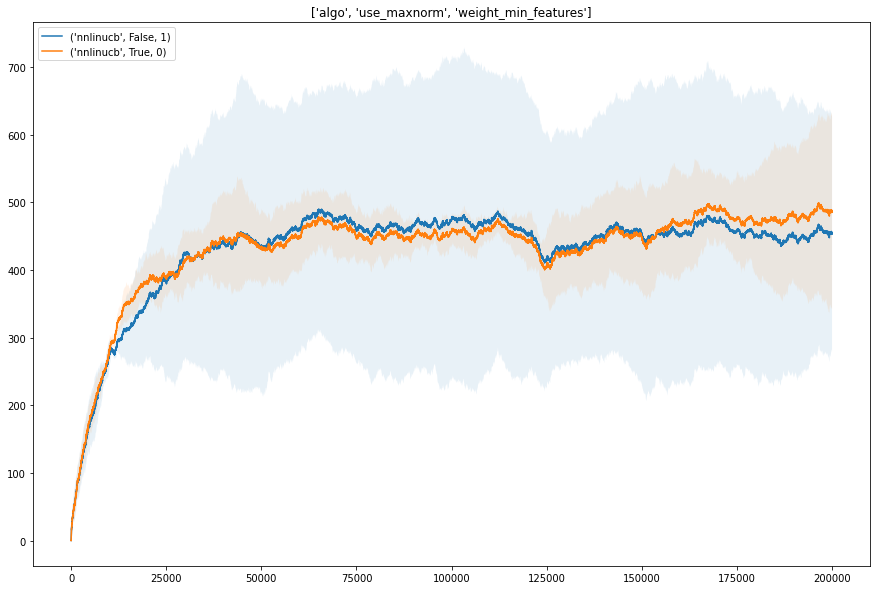

In [2]:
keys = df.columns[~df.columns.isin(result_keys+['seed'])]
m2 = (df[keys] == df[keys].iloc[0]).all()
gk = keys[~m2].values.tolist()
print("keys for grouping: ", gk)
if len(gk) == 0:
    gk = "algo"
    print("new keys for grouping: ", gk)
if "algo" not in gk:
    gkn = gk
    gk = ["algo"]
    gk.extend(gkn)
print("keys for grouping: ", gk)
grouped = df.groupby(gk)

max_t = None
plt.figure(figsize=(15,10))
data = {}
for name, group in grouped:
    print(name)
    lengths = np.array([len(el) for el in group['regret'].values])
    idxs = np.argsort(lengths)[::-1]
    if not np.all(lengths == lengths.min()):
        print(f"not all runs have finished {lengths[idxs]}")
    idxs = idxs
    print(f"selecting idxs {idxs}")
    ml = lengths[idxs].min()
    regrets = np.stack([el[:ml] for el in group['regret'].values[idxs]], axis=0)
    reps = regrets.shape[0]
    mean_regret = regrets.mean(axis=0)[:max_t]
    std_regret = regrets.std(axis=0)[:max_t] / np.sqrt(reps)
    data[name] = {
        "mean_regret": mean_regret,
        "ci": std_regret
    }
    if "leader" in name:
        plt.plot(mean_regret, "--", label=f"{name}")
    elif name[0].startswith("leaderselect_mineig"):
        plt.plot(mean_regret, ":", label=f"{name}")
    else:
        plt.plot(mean_regret, label=f"{name}")
    plt.fill_between(np.arange(mean_regret.shape[0]), mean_regret -2*std_regret, mean_regret+2*std_regret, alpha=0.1)

plt.legend(loc='upper left')
plt.title(f"{gk}")

data["legend"] = gk

pickle.dump(data, open( f"{prefix}results.p", "wb" ) )